In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader, DataListLoader
import IPython.display
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from load_data import BatchData
import summary

USE_GPU = True
HIDDEN_CHANNELS = 10
LATENT_DIMS =   4
NUM_GCN = 4 #assuming symmetric encoder-decoder network

device = torch.device("cuda")

/home/maximus/anaconda3/envs/gnn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Encoder(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, latent_dims, num_layers):
        super(Encoder, self).__init__()
        self.linear = torch.nn.Linear(num_node_features, hidden_channels)
        self.conv_layers = torch.nn.ModuleList()
        for i in range(num_layers-1):
            self.conv_layers.append(GCNConv(hidden_channels, hidden_channels)) # GCN layers 2 to num_layers-1
            # hidden_channels = hidden_channels - 2 # lets try 
        self.conv_layers.append(GCNConv(hidden_channels, latent_dims)) # GCN layer num_layers
        self.num_layers = num_layers

    def forward(self, x, edge_index):
    # Linear transformation
        x = self.linear(x)
        x = F.relu(x)
        # Message passing
        for i in range(self.num_layers-1):
            x = self.conv_layers[i](x, edge_index)
            x = F.relu(x)
        # Non-linearity
        x = self.conv_layers[-1](x, edge_index)
        return x

In [3]:
class Decoder(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, latent_dims):
        super(Decoder, self).__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(latent_dims, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, num_node_features)
        )

    def forward(self, z, edge_index):
        # Compute node embeddings
        z = self.mlp(z)
        # Compute probability of edge existence
        prob = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        prob = torch.sigmoid(prob)
        return prob

In [4]:
class Autoencoder(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super(Autoencoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    
  def forward(self, x, edge_index):
    # Apply the MLP to the feature vectors
    z = self.encoder(x, edge_index)
    # Apply the GNN to the graph and feature vectors
    pred = self.decoder(z, edge_index)
    return pred

In [59]:
def focal_loss(pred, target):
        alpha  = 0.2
        gamma = 0.5
        print(pred.shape)
        pred = pred.unsqueeze(1)
        print(pred.shape)

        input_soft = F.softmax(pred, dim=1)
        
        one_hot = torch.zeros(pred.shape[0], 2, dtype=torch.int64, device=pred.device)
        pred = one_hot.scatter_(1, pred, 1)
        weight = torch.pow(1. - input_soft, gamma)
        focal = -alpha * weight * torch.log(input_soft)
        loss_tmp = torch.sum(pred * focal, dim=1)
        loss = torch.mean(loss_tmp)
        return loss
  

In [60]:
def displayStats(loader):
        for batch in loader:
            print(batch)
            data = batch  # Get the first graph object.
            print(data)
            print('==============================================================')
            # Gather some statistics about the graph.
            print(f'Number of nodes: {data.num_nodes}')
            print(f'Number of edges: {data.num_edges}')
            print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
            print(f'Number of node features: {data.num_features}')
            print(f'Number of edge features: {data.edge_attr.shape[1]}')
            # print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
            print(f'Has isolated nodes: {data.has_isolated_nodes()}')
            print(f'Has self-loops: {data.has_self_loops()}')
            print(f'Is undirected: {data.is_undirected()}')
            break
        return None

def test_visualise(graph):
    g = torch_geometric.utils.to_networkx(graph, to_undirected=True)
    nx.draw_networkx(g)
    plt.show()
    return None

def getDataDims(loader):
    return [loader.dataset[0].num_features, loader.dataset[0].edge_attr.shape[1]]


In [61]:
def train_model(model, loader_train, loader_test, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_history =[]
    roc_history =[]
    ap_history =[]
    
    for epoch in range(num_epochs):
        for batch in loader_train:
            if(USE_GPU):
                x           = batch["x"].to("cuda")
                edge_index  = batch["edge_index"].to("cuda")
                edge_attr   = batch["edge_attr"].to("cuda")
                y           = batch["y"].to("cuda")
            probs = model.forward(x, edge_index)
            # loss = F.binary_cross_entropy(probs, y)
            loss = focal_loss(probs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            roc_auc, ap = test(model, loader_test)
            
        loss_history.append(float(loss.item()))
        roc_history.append(roc_auc)
        ap_history.append(ap)    
        if(epoch%1==0):
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}, ROC Score: {roc_auc:.4f}, AP Score: {ap:.4f}")
        del loss
        del probs    
        torch.cuda.empty_cache()
    return loss_history, roc_history, ap_history

def test(model, loader):
    for batch in loader:
        if(USE_GPU):
            x           = batch["x"].to("cuda")
            edge_index  = batch["edge_index"].to("cuda")
            edge_attr   = batch["edge_attr"].to("cuda")
            y           = batch["y"].to("cuda")
        probs = model.forward(x, edge_index)
    y, pred = y.detach().cpu().numpy(), probs.detach().cpu().numpy()
    
    return roc_auc_score(y, pred), average_precision_score(y, pred)
    

In [62]:
def init_model(num_nf, num_hidden_channels, latent_dims, num_gcn, loader):
    encoder = Encoder(num_nf, num_hidden_channels, latent_dims, num_gcn)
    decoder = Decoder(num_nf, num_hidden_channels, latent_dims)
    model = Autoencoder(encoder, decoder)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    print(summary.summary(model, loader.dataset[0]["x"], loader.dataset[0]["edge_index"]))
    return model

In [63]:
## TODO: Change to DataListLoader to allow batches to be subscriptable and possibly add functionality for parallelisation

## TODO: init BatchData with an index range instead to allow 80 20 train-test split

loader_train = DataLoader(BatchData(0,1), batch_size=16, pin_memory=True, num_workers=4)
print("Train Set Batch Count:", len(loader_train))
displayStats(loader=loader_train)
loader_test = DataLoader(BatchData(9,10), batch_size=16, pin_memory=True, num_workers=4)
print("Test Set Batch Count:", len(loader_train))
displayStats(loader=loader_test)
num_nf, num_ef = getDataDims(loader=loader_train)


Loading:
../data/batch_1_0
Train Set Batch Count: 63
DataBatch(x=[4822, 6], edge_index=[2, 67604], edge_attr=[67604, 4], y=[67604], batch=[4822], ptr=[17])
DataBatch(x=[4822, 6], edge_index=[2, 67604], edge_attr=[67604, 4], y=[67604], batch=[4822], ptr=[17])
Number of nodes: 4822
Number of edges: 67604
Average node degree: 14.02
Number of node features: 6
Number of edge features: 4
Has isolated nodes: True
Has self-loops: False
Is undirected: False
Loading:
../data/batch_1_9
Test Set Batch Count: 63
DataBatch(x=[4754, 6], edge_index=[2, 64870], edge_attr=[64870, 4], y=[64870], batch=[4754], ptr=[17])
DataBatch(x=[4754, 6], edge_index=[2, 64870], edge_attr=[64870, 4], y=[64870], batch=[4754], ptr=[17])
Number of nodes: 4754
Number of edges: 64870
Average node degree: 13.65
Number of node features: 6
Number of edge features: 4
Has isolated nodes: True
Has self-loops: False
Is undirected: False


In [64]:
model = init_model(num_nf, HIDDEN_CHANNELS, LATENT_DIMS, NUM_GCN, loader_train)

+--------------------------------+----------------------+----------------+----------+
| Layer                          | Input Shape          | Output Shape   | #Param   |
|--------------------------------+----------------------+----------------+----------|
| Autoencoder                    | [350, 6], [2, 8138]  | [8138]         | 560      |
| ├─(encoder)Encoder             | [350, 6], [2, 8138]  | [350, 4]       | 444      |
| │    └─(linear)Linear          | [350, 6]             | [350, 10]      | 70       |
| │    └─(conv_layers)ModuleList | --                   | --             | 374      |
| │    │    └─(0)GCNConv         | [350, 10], [2, 8138] | [350, 10]      | 110      |
| │    │    └─(1)GCNConv         | [350, 10], [2, 8138] | [350, 10]      | 110      |
| │    │    └─(2)GCNConv         | [350, 10], [2, 8138] | [350, 10]      | 110      |
| │    │    └─(3)GCNConv         | [350, 10], [2, 8138] | [350, 4]       | 44       |
| ├─(decoder)Decoder             | [350, 4], [2, 8138]

In [65]:
if(USE_GPU):
    model.to(device = "cuda")
    torch.cuda.empty_cache()

print("Training on GPU:", next(model.parameters()).is_cuda)
loss_hist, roc_hist, ap_hist = train_model(model, loader_train, loader_test, num_epochs = 25)

Training on GPU: True
torch.Size([67604])
torch.Size([67604, 1])


RuntimeError: scatter(): Expected dtype int64 for index

In [ ]:

plt.plot(roc_hist, label="ROC")
plt.plot(ap_hist, label="AP")
plt.legend(loc="upper right")
plt.show()

NameError: name 'roc_hist' is not defined

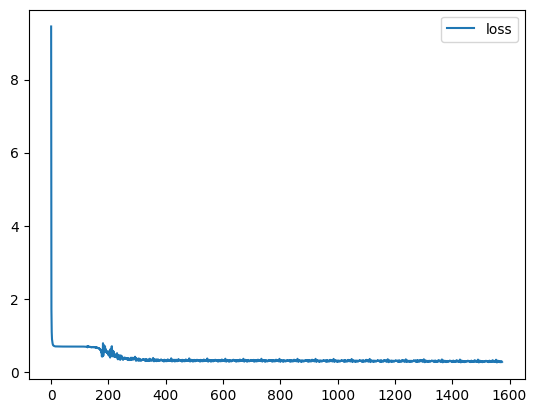

In [ ]:
plt.plot(loss_hist, label="loss")
plt.legend()
plt.show()
roc_auc, ap = test(model, loader_test)

In [ ]:
print("ROC:{}%".format(roc_auc*100))
print("Average Precision:{}%".format(ap*100))

ROC:86.57885243934498%
Average Precision:73.68401056323131%
